In [1]:
import numpy as np 
import pandas as pd 
import json
import re

from tqdm import tqdm 
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import collections
import wordcloud
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.model_selection import GridSearchCV
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
import spacy
import gensim.corpora as corpora
from gensim.models import LdaMulticore, CoherenceModel, Phrases, LdaModel
import time
from bokeh.models import ColumnDataSource, HoverTool
from bokeh.plotting import figure,show,output_notebook
import pyLDAvis
import pyLDAvis.gensim_models
from sentence_transformers import SentenceTransformer
import warnings
import pprint

import matplotlib.pyplot as plt
plt.style.use('ggplot')

/Users/laiduy98/miniconda3/envs/ter/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
root_path = '../../archive'
metadata_path = f'{root_path}/metadata.csv'
meta_df = pd.read_csv(metadata_path, dtype={
    'pubmed_id': str,
    'doi': str
})
meta_df.head()

/var/folders/yf/jsht06l94t5_wb6s1c65k6v40000gn/T/ipykernel_19742/1567045245.py:3: DtypeWarning: Columns (1,5,13,14,15,16) have mixed types. Specify dtype option on import or set low_memory=False.
  meta_df = pd.read_csv(metadata_path, dtype={


,cord_uid,sha,source_x,title,doi,pmcid,pubmed_id,license,abstract,publish_time,authors,journal,mag_id,who_covidence_id,arxiv_id,pdf_json_files,pmc_json_files,url,s2_id
0,ug7v899j,d1aafb70c066a2068b02786f8929fd9c900897fb,PMC,Clinical features of culture-proven Mycoplasma...,10.1186/1471-2334-1-6,PMC35282,11472636,no-cc,OBJECTIVE: This retrospective chart review des...,2001-07-04,"Madani, Tariq A; Al-Ghamdi, Aisha A",BMC Infect Dis,NaN,NaN,NaN,document_parses/pdf_json/d1aafb70c066a2068b027...,document_parses/pmc_json/PMC35282.xml.json,https://www.ncbi.nlm.nih.gov/pmc/articles/PMC3...,NaN
1,02tnwd4m,6b0567729c2143a66d737eb0a2f63f2dce2e5a7d,PMC,Nitric oxide: a pro-inflammatory mediator in l...,10.1186/rr14,PMC59543,11667967,no-cc,Inflammatory diseases of the respiratory tract...,2000-08-15,"Vliet, Albert van der; Eiserich, Jason P; Cros...",Respir Res,NaN,NaN,NaN,document_parses/pdf_json/6b0567729c2143a66d737...,document_parses/pmc_json/PMC59543.xml.json,https://www.ncbi.nlm.nih.gov/pmc/articles/PMC5...,NaN
2,ejv2xln0,06ced00a5fc04215949aa72528f2eeaae1d58927,PMC,Surfactant protein-D and pulmonary host defense,10.1186/rr19,PMC59549,11667972,no-cc,Surfactant protein-D (SP-D) participates in th...,2000-08-25,"Crouch, Erika C",Respir Res,NaN,NaN,NaN,document_parses/pdf_json/06ced00a5fc04215949aa...,document_parses/pmc_json/PMC59549.xml.json,https://www.ncbi.nlm.nih.gov/pmc/articles/PMC5...,NaN
3,2b73a28n,348055649b6b8cf2b9a376498df9bf41f7123605,PMC,Role of endothelin-1 in lung disease,10.1186/rr44,PMC59574,11686871,no-cc,Endothelin-1 (ET-1) is a 21 amino acid peptide...,2001-02-22,"Fagan, Karen A; McMurtry, Ivan F; Rodman, David M",Respir Res,NaN,NaN,NaN,document_parses/pdf_json/348055649b6b8cf2b9a37...,document_parses/pmc_json/PMC59574.xml.json,https://www.ncbi.nlm.nih.gov/pmc/articles/PMC5...,NaN
4,9785vg6d,5f48792a5fa08bed9f56016f4981ae2ca6031b32,PMC,Gene expression in epithelial cells in respons...,10.1186/rr61,PMC59580,11686888,no-cc,Respiratory syncytial virus (RSV) and pneumoni...,2001-05-11,"Domachowske, Joseph B; Bonville, Cynthia A; Ro...",Respir Res,NaN,NaN,NaN,document_parses/pdf_json/5f48792a5fa08bed9f560...,document_parses/pmc_json/PMC59580.xml.json,https://www.ncbi.nlm.nih.gov/pmc/articles/PMC5...,NaN


In [3]:
meta_df.count()

cord_uid            1015768
sha                  351674
source_x            1015768
title               1015273
doi                  620123
pmcid                366727
pubmed_id            470047
license             1015768
abstract             785160
publish_time        1013952
authors              992939
journal              930544
mag_id                    0
who_covidence_id     470248
arxiv_id              13588
pdf_json_files       351674
pmc_json_files       295705
url                  649539
s2_id                939940
dtype: int64

In [4]:
meta_df.columns

Index(['cord_uid', 'sha', 'source_x', 'title', 'doi', 'pmcid', 'pubmed_id',
       'license', 'abstract', 'publish_time', 'authors', 'journal', 'mag_id',
       'who_covidence_id', 'arxiv_id', 'pdf_json_files', 'pmc_json_files',
       'url', 's2_id'],
      dtype='object')

## Choose paper to process

- 2021 or newer
- delete with missing abstract
- delete with duplicated abstract

In [5]:
meta_df = meta_df[meta_df.publish_time>='2021']
meta_df.dropna(axis=0,how='any',subset=['abstract'],inplace=True)
meta_df.drop_duplicates(subset=['abstract'],keep='first',inplace=True)

In [6]:
meta_df.count()

cord_uid            394019
sha                 169267
source_x            394019
title               393972
doi                 289955
pmcid               164313
pubmed_id           199711
license             394019
abstract            394019
publish_time        394019
authors             392821
journal             359234
mag_id                   0
who_covidence_id    171060
arxiv_id              7206
pdf_json_files      169267
pmc_json_files      146622
url                 297980
s2_id               368222
dtype: int64

In [173]:
import random

random.seed(42)

data = meta_df.sample(n=50000)

## Stopwords

In [174]:
import string
import spacy
from spacy.lang.en.stop_words import STOP_WORDS

punctuations = string.punctuation
stopwords = list(STOP_WORDS)
stopwords[:10]

['yourself', 'them', 'we', '’re', 'up', "'re", 'for', 'except', 'her', 'same']

In [175]:
custom_stop_words = [
    'doi', 'preprint', 'copyright', 'peer', 'reviewed', 'org', 'https', 'et', 'al', 'author', 'figure', 
    'rights', 'reserved', 'permission', 'used', 'using', 'biorxiv', 'medrxiv', 'license', 'fig', 'fig.', 
    'al.', 'Elsevier', 'PMC', 'CZI'
]

for w in custom_stop_words:
    if w not in stopwords:
        stopwords.append(w)
        
lst_stopwords = stopwords

In [176]:
data['abstract'] = data['abstract'].apply(lambda x: x.strip().lower())
data['abstract_clean'] = data['abstract'].apply(lambda x: x.split())

# Take only English paper
data['abstract_clean'] = data['abstract_clean'].apply(lambda x: [w for w in x if w.isalpha()])
# Remove Stopwords
data['abstract_clean'] = data['abstract_clean'].apply(lambda x: [w for w in x if w not in lst_stopwords])
# Remove words with single characters
data['abstract_clean'] = data['abstract_clean'].apply(lambda x: [w for w in x if len(w)>1])
data.head()

,cord_uid,sha,source_x,title,doi,pmcid,pubmed_id,license,abstract,publish_time,authors,journal,mag_id,who_covidence_id,arxiv_id,pdf_json_files,pmc_json_files,url,s2_id,abstract_clean
223757,ra8bd7gd,NaN,WHO,Audience Engagement with COVID-19 News: The Im...,10.1080/1461670x.2021.1931410,NaN,NaN,unk,existing research on media and the covid-19 pa...,2021,"Mihelj, S.; Kondor, K.; Stetka, V.",Journalism Studies,NaN,#covidwho-1557476,NaN,NaN,NaN,https://doi.org/10.1080/1461670x.2021.1931410,236390433.0,"[existing, research, media, pandemic, largely,..."
863459,qgyn036p,NaN,Medline; WHO,[Development of autoimmune hemolytic anemia af...,10.11406/rinketsu.62.1510,NaN,34732625,unk,a 75-year-old woman with a history of postoper...,2021,"Okuno, Shingo; Hashimoto, Ken; Shimizu, Rie; T...",Rinsho Ketsueki,NaN,#covidwho-1502774,NaN,NaN,NaN,https://www.ncbi.nlm.nih.gov/pubmed/34732625/;...,242945002.0,"[woman, history, postoperative, chemotherapy, ..."
249687,rtpe4ult,NaN,WHO,Polysulfate hemmen durch elektrostatische Wech...,10.1002/ange.202102717,NaN,NaN,unk,"wir zeigen, dass negativ geladene polysulfate ...",2021,"Nie, Chuanxiong Paria Pouyan Lauster Daniel Tr...",Angewandte Chemie,NaN,#covidwho-1300361,NaN,NaN,NaN,https://doi.org/10.1002/ange.202102717,236223877.0,"[wir, dass, negativ, geladene, polysulfate, du..."
923221,d8tmbl28,ad6d7367e5f8c125253b0f8b053d7bca74f66851,Elsevier; PMC; WHO,Soil governance in a pandemic,10.1016/j.soisec.2021.100033,PMC8719905,NaN,els-covid,covid-19 exacerbated many threats to soil heal...,2022-03-31,"Farnese, Patricia L.",Soil Security,NaN,NaN,NaN,document_parses/pdf_json/ad6d7367e5f8c125253b0...,NaN,https://api.elsevier.com/content/article/pii/S...,245496212.0,"[exacerbated, threats, soil, consequences, pan..."
429019,uzup3fk0,NaN,WHO,A Case of ST-Elevation Acute Myocardial Infarc...,NaN,NaN,NaN,unk,abstract we experienced a case of primary perc...,2021,"Shimai, Ryosuke Ouchi Shohei Miyazaki Tetsuro ...",Clinical Case Reports,NaN,#covidwho-1408684,NaN,NaN,NaN,NaN,237592109.0,"[abstract, experienced, case, primary, percuta..."


In [177]:
data.reset_index(drop=True,inplace=True)

In [178]:
inverted_idx = {}
for idx,sentence in enumerate(list(data['abstract_clean'])):
    for token in set(sentence):
        if token not in inverted_idx:
            inverted_idx[token] = [idx]
        else:
            inverted_idx[token].append(idx)

print(f'There are {len(inverted_idx)} unique words in inverted index')

There are 98352 unique words in inverted index


In [179]:
data['abstract_clean']

0        [existing, research, media, pandemic, largely,...
1        [woman, history, postoperative, chemotherapy, ...
2        [wir, dass, negativ, geladene, polysulfate, du...
3        [exacerbated, threats, soil, consequences, pan...
4        [abstract, experienced, case, primary, percuta...
                               ...                        
49995    [mathematical, models, epidemiology, indispens...
49996    [persons, drug, use, disorders, underserved, s...
49997    [maps, convey, hazard, risk, information, play...
49998    [standardized, investigation, epileptic, seizu...
49999    [rapidly, evolving, pandemic, created, need, t...
Name: abstract_clean, Length: 50000, dtype: object

In [180]:
keywords_risk = ['risk','risky','risks','risked','risking', 'severity', 'severe']
risk_idx = []
for word in keywords_risk:
    try:
        risk_idx += inverted_idx[word]
    except:
        pass
risk_idx = list(set(risk_idx))
print(f'Found {len(risk_idx)} articles related to risk')

Found 15278 articles related to risk


In [181]:
risk_article = data.iloc[risk_idx,:]
risk_article.head()

,cord_uid,sha,source_x,title,doi,pmcid,pubmed_id,license,abstract,publish_time,authors,journal,mag_id,who_covidence_id,arxiv_id,pdf_json_files,pmc_json_files,url,s2_id,abstract_clean
1,qgyn036p,NaN,Medline; WHO,[Development of autoimmune hemolytic anemia af...,10.11406/rinketsu.62.1510,NaN,34732625,unk,a 75-year-old woman with a history of postoper...,2021,"Okuno, Shingo; Hashimoto, Ken; Shimizu, Rie; T...",Rinsho Ketsueki,NaN,#covidwho-1502774,NaN,NaN,NaN,https://www.ncbi.nlm.nih.gov/pubmed/34732625/;...,242945002.0,"[woman, history, postoperative, chemotherapy, ..."
4,uzup3fk0,NaN,WHO,A Case of ST-Elevation Acute Myocardial Infarc...,NaN,NaN,NaN,unk,abstract we experienced a case of primary perc...,2021,"Shimai, Ryosuke Ouchi Shohei Miyazaki Tetsuro ...",Clinical Case Reports,NaN,#covidwho-1408684,NaN,NaN,NaN,NaN,237592109.0,"[abstract, experienced, case, primary, percuta..."
32775,1cbbdmjb,5ae79ee8c64d0641726d20caf688d21afbe1afe0,Medline; PMC,Development of a SARS‐CoV‐2 rapid antibody det...,10.1111/crj.13331,PMC8014806,33484220,no-cc,introduction: severe acute respiratory syndrom...,2021-02-04,"Wang, Huihui; Li, Xuemei; Li, Tao; Wang, Lianz...",Clin Respir J,NaN,NaN,NaN,document_parses/pdf_json/5ae79ee8c64d0641726d2...,document_parses/pmc_json/PMC8014806.xml.json,https://www.ncbi.nlm.nih.gov/pubmed/33484220/;...,231687438.0,"[severe, acute, respiratory, syndrome, coronav..."
32778,b6axdask,39c7ff69712fc641faf1b185fe9c4ef93bf5fdef,Elsevier; Medline; PMC; WHO,Effectiveness of Monoclonal Antibodies in Prev...,10.1016/j.mayocp.2021.12.002,PMC8674496,35120695,els-covid,anti-spike monoclonal antibodies have proven i...,2021-12-16,"O’Horo, John C.; Challener, Douglas W.; Speich...",Mayo Clin Proc,NaN,NaN,NaN,document_parses/pdf_json/39c7ff69712fc641faf1b...,NaN,https://api.elsevier.com/content/article/pii/S...,245145415.0,"[monoclonal, antibodies, proven, invaluable, p..."
32781,nwnrm24l,ac6322cbebc7883e93580b9ee8cbe5d1a556dc3a,PMC,"Risk perception, mental health distress, and f...",10.1007/s12144-021-02624-4,PMC8754583,NaN,no-cc,the covid-19 pandemic has brought unprecedente...,2022-01-13,"Zhang, Ning",Curr Psychol,NaN,NaN,NaN,document_parses/pdf_json/ac6322cbebc7883e93580...,document_parses/pmc_json/PMC8754583.xml.json,https://www.ncbi.nlm.nih.gov/pmc/articles/PMC8...,NaN,"[pandemic, brought, unprecedented, disruptions..."


In [182]:
def lemmatization(texts, allowed_postags=['NOUN','ADJ','VERB','ADV']): #['NOUN','ADJ','VERB','ADV'] ['DISEASE', 'CHEMICAL']
    texts_out = []
    nlp = spacy.load('en_ner_bc5cdr_md', disable=['parser', 'ner']) #en_core_web_sm  en_ner_bc5cdr_md
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        #'-PRON-' is used as the lemma for all pronouns such as their, you, me, and I
        texts_out.append([token.lemma_ if token.lemma_ not in ['-PRON-'] else '' 
                          for token in doc if token.pos_ in allowed_postags])
    return texts_out   


/var/folders/yf/jsht06l94t5_wb6s1c65k6v40000gn/T/ipykernel_19742/2083282534.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  risk_article['Lemma_Tokens'] = lemmatization(list(risk_article['abstract_clean']))
/var/folders/yf/jsht06l94t5_wb6s1c65k6v40000gn/T/ipykernel_19742/2083282534.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  risk_article['Phrase_Lemma_Tokens'] = risk_article['Lemma_Tokens'].apply(lambda x: bigram[x])


Text(0.5, 1.0, 'Significant word after filtering only risk factor paper')

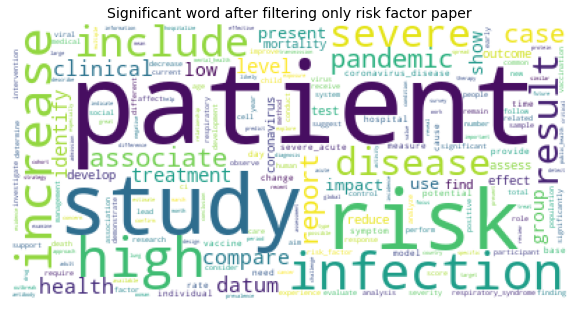

In [183]:
risk_article['Lemma_Tokens'] = lemmatization(list(risk_article['abstract_clean']))

bigram = Phrases(list(risk_article['Lemma_Tokens']), min_count=3)
risk_article['Phrase_Lemma_Tokens'] = risk_article['Lemma_Tokens'].apply(lambda x: bigram[x])

risk_abstract_tokens = []
for tokens in list(risk_article['Phrase_Lemma_Tokens']):
    risk_abstract_tokens += tokens
risk_wordcnt_dict = collections.Counter(risk_abstract_tokens)

wcloud = wordcloud.WordCloud(background_color='white')
wcloud.generate_from_frequencies(risk_wordcnt_dict)
fig,ax = plt.subplots(figsize=(10,8))
ax.imshow(wcloud)
for pos in ['left','right','top','bottom']:
    ax.spines[pos].set_color(None)
ax.set_xticks([])
ax.set_yticks([])
ax.set_title('Significant word after filtering only risk factor paper' ,fontsize=14)

In [184]:
risk_article.head()

,cord_uid,sha,source_x,title,doi,pmcid,pubmed_id,license,abstract,publish_time,...,mag_id,who_covidence_id,arxiv_id,pdf_json_files,pmc_json_files,url,s2_id,abstract_clean,Lemma_Tokens,Phrase_Lemma_Tokens
1,qgyn036p,NaN,Medline; WHO,[Development of autoimmune hemolytic anemia af...,10.11406/rinketsu.62.1510,NaN,34732625,unk,a 75-year-old woman with a history of postoper...,2021,...,NaN,#covidwho-1502774,NaN,NaN,NaN,https://www.ncbi.nlm.nih.gov/pubmed/34732625/;...,242945002.0,"[woman, history, postoperative, chemotherapy, ...","[woman, history, postoperative, chemotherapy, ...","[woman, history, postoperative, chemotherapy, ..."
4,uzup3fk0,NaN,WHO,A Case of ST-Elevation Acute Myocardial Infarc...,NaN,NaN,NaN,unk,abstract we experienced a case of primary perc...,2021,...,NaN,#covidwho-1408684,NaN,NaN,NaN,NaN,237592109.0,"[abstract, experienced, case, primary, percuta...","[abstract, experienced, case, primary, percuta...","[abstract, experienced, case, primary, percuta..."
32775,1cbbdmjb,5ae79ee8c64d0641726d20caf688d21afbe1afe0,Medline; PMC,Development of a SARS‐CoV‐2 rapid antibody det...,10.1111/crj.13331,PMC8014806,33484220,no-cc,introduction: severe acute respiratory syndrom...,2021-02-04,...,NaN,NaN,NaN,document_parses/pdf_json/5ae79ee8c64d0641726d2...,document_parses/pmc_json/PMC8014806.xml.json,https://www.ncbi.nlm.nih.gov/pubmed/33484220/;...,231687438.0,"[severe, acute, respiratory, syndrome, coronav...","[severe, acute, respiratory, syndrome, coronav...","[severe_acute, respiratory_syndrome, coronavir..."
32778,b6axdask,39c7ff69712fc641faf1b185fe9c4ef93bf5fdef,Elsevier; Medline; PMC; WHO,Effectiveness of Monoclonal Antibodies in Prev...,10.1016/j.mayocp.2021.12.002,PMC8674496,35120695,els-covid,anti-spike monoclonal antibodies have proven i...,2021-12-16,...,NaN,NaN,NaN,document_parses/pdf_json/39c7ff69712fc641faf1b...,NaN,https://api.elsevier.com/content/article/pii/S...,245145415.0,"[monoclonal, antibodies, proven, invaluable, p...","[monoclonal, antibody, prove, invaluable, prev...","[monoclonal_antibody, prove, invaluable, preve..."
32781,nwnrm24l,ac6322cbebc7883e93580b9ee8cbe5d1a556dc3a,PMC,"Risk perception, mental health distress, and f...",10.1007/s12144-021-02624-4,PMC8754583,NaN,no-cc,the covid-19 pandemic has brought unprecedente...,2022-01-13,...,NaN,NaN,NaN,document_parses/pdf_json/ac6322cbebc7883e93580...,document_parses/pmc_json/PMC8754583.xml.json,https://www.ncbi.nlm.nih.gov/pmc/articles/PMC8...,NaN,"[pandemic, brought, unprecedented, disruptions...","[pandemic, bring, unprecedented, disruption, e...","[pandemic_bring, unprecedented_disruption, eve..."


100%|███████████████████████████████████████████████████████████████████████████| 8/8 [07:08<00:00, 53.55s/it]

Topic number selection took 428.38461422920227 seconds


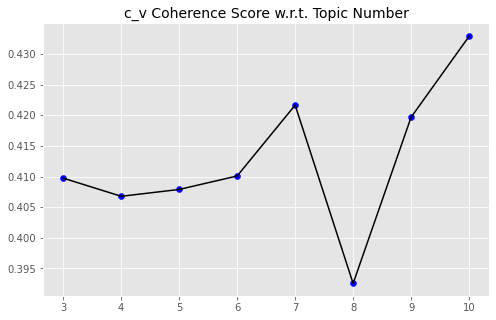

In [185]:
id2token_risk_article = corpora.Dictionary(list(risk_article['Phrase_Lemma_Tokens']))

corpus_risk_article = [id2token_risk_article.doc2bow(tokens) 
                        for tokens in list(risk_article['Phrase_Lemma_Tokens'])]

begin_time = time.time()
coherence_scores = []
for nb_topics in tqdm(range(3,11)):
    lda_model = LdaMulticore(corpus=corpus_risk_article,
                            id2word=id2token_risk_article,
                            num_topics=nb_topics, 
                            random_state=98,
                            chunksize=100,
                            passes=10,
                            iterations=50,
                            decay=0.5,
                            per_word_topics=True,)

    cm = CoherenceModel(model=lda_model, 
                        texts=list(risk_article['Phrase_Lemma_Tokens']),
                        dictionary=id2token_risk_article,
                        coherence='c_v',
                        topn=20)
    coherence_score = cm.get_coherence()
    coherence_scores.append(coherence_score)
    
print(f'Topic number selection took {time.time()-begin_time} seconds')

fig,ax = plt.subplots(figsize=(8,5))
ax.plot(range(3,11),coherence_scores,color='black')
ax.scatter(range(3,11),coherence_scores,marker='o',color='blue')
ax.set_xticks(range(3,11,1))
ax.set_title('c_v Coherence Score w.r.t. Topic Number',fontsize=14)
#ax.set_xlabel('Number of Topics',fontsize=14)
for pos in ['top','right']:
    ax.spines[pos].set_color(None)

In [186]:
corpus_risk_article[0]

[(0, 1),
 (1, 1),
 (2, 1),
 (3, 3),
 (4, 1),
 (5, 1),
 (6, 1),
 (7, 1),
 (8, 1),
 (9, 1),
 (10, 1),
 (11, 1),
 (12, 1),
 (13, 1),
 (14, 2),
 (15, 1),
 (16, 1),
 (17, 1),
 (18, 1),
 (19, 1),
 (20, 1),
 (21, 1),
 (22, 1),
 (23, 1),
 (24, 2),
 (25, 1),
 (26, 1),
 (27, 1),
 (28, 2),
 (29, 1),
 (30, 1),
 (31, 1),
 (32, 2),
 (33, 2),
 (34, 1),
 (35, 1),
 (36, 1),
 (37, 1),
 (38, 1),
 (39, 1),
 (40, 1),
 (41, 1),
 (42, 2),
 (43, 1),
 (44, 1),
 (45, 1),
 (46, 1),
 (47, 1),
 (48, 1),
 (49, 1),
 (50, 1),
 (51, 1),
 (52, 1),
 (53, 1),
 (54, 1),
 (55, 1),
 (56, 1)]

In [187]:
len(list(risk_article['Phrase_Lemma_Tokens']))

15278

In [188]:
lda_model = LdaMulticore(corpus=corpus_risk_article,
                        id2word=id2token_risk_article,
                        num_topics=6, 
                        random_state=98,
                        chunksize=100,
                        passes=10,
                        iterations=50,
                        decay=0.5,
                        per_word_topics=True,)

print('Perplexity: ', lda_model.log_perplexity(corpus_risk_article))

Perplexity:  -8.17613863301685


/var/folders/yf/jsht06l94t5_wb6s1c65k6v40000gn/T/ipykernel_19742/3526752618.py:12: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(labels=words, fontsize=14)
/var/folders/yf/jsht06l94t5_wb6s1c65k6v40000gn/T/ipykernel_19742/3526752618.py:12: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(labels=words, fontsize=14)
/var/folders/yf/jsht06l94t5_wb6s1c65k6v40000gn/T/ipykernel_19742/3526752618.py:12: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(labels=words, fontsize=14)
/var/folders/yf/jsht06l94t5_wb6s1c65k6v40000gn/T/ipykernel_19742/3526752618.py:12: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(labels=words, fontsize=14)
/var/folders/yf/jsht06l94t5_wb6s1c65k6v40000gn/T/ipykernel_19742/3526752618.py:12: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabe

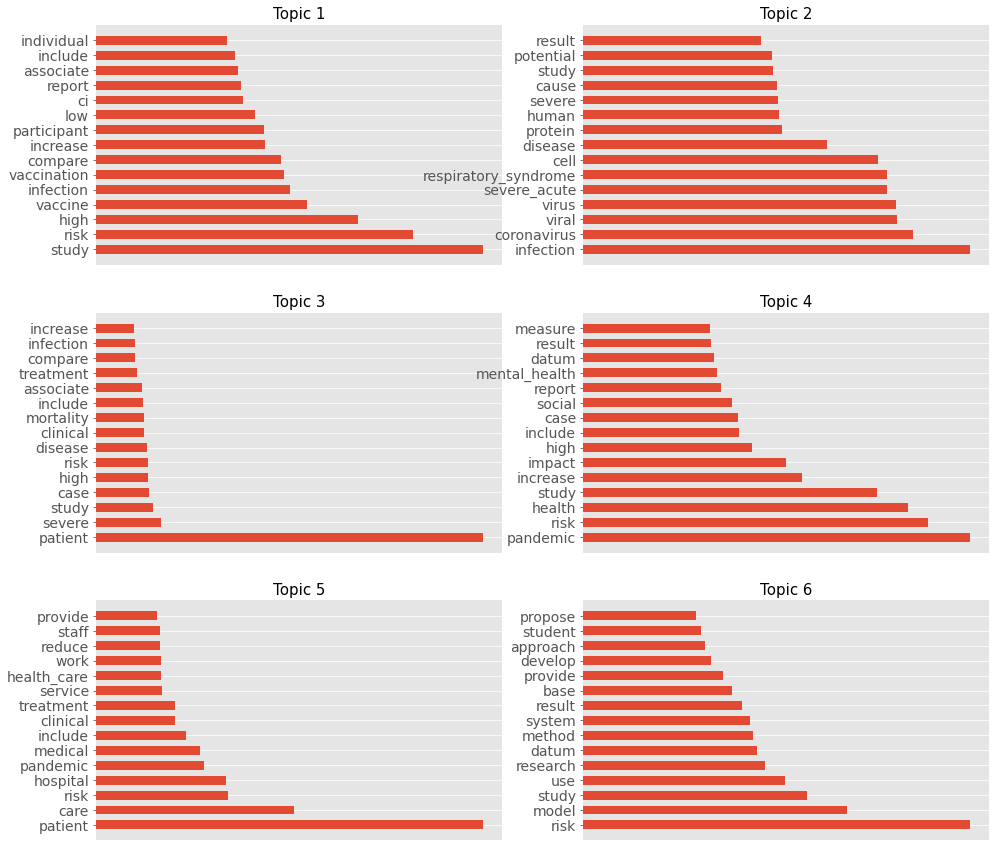

In [189]:
word_topic_scores = lda_model.show_topics(num_words=15,formatted=False)

fig = plt.figure(figsize=(16,15))
for i,topic in enumerate(word_topic_scores):
    word_score_pairs = topic[1]
    #word_score_dict = dict(topic[1])
    words = [word_score_pair[0] for word_score_pair in word_score_pairs]
    probs = [word_score_pair[1] for word_score_pair in word_score_pairs]
    #fig,ax = plt.subplots(figsize=(7,5))
    ax = fig.add_subplot(3,2,i+1)
    ax.barh(y=words,width=probs,height=0.6)
    ax.set_yticklabels(labels=words, fontsize=14)
    ax.set_xticks([])
    ax.set_title(f'Topic {i+1}',fontsize=15)
    for pos in ['left','right','bottom','top']:
        ax.spines[pos].set_color(None)

In [190]:
%%time
pyLDAvis.enable_notebook()
pyLDAvis.gensim_models.prepare(lda_model, corpus_risk_article, id2token_risk_article)

/Users/laiduy98/miniconda3/envs/ter/lib/python3.9/site-packages/pyLDAvis/_prepare.py:246: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  default_term_info = default_term_info.sort_values(
/Users/laiduy98/miniconda3/envs/ter/lib/python3.9/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/Users/laiduy98/miniconda3/envs/ter/lib/python3.9/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/Users/laiduy98/miniconda3/envs/ter/lib/python3.9/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/User

CPU times: user 6.32 s, sys: 824 ms, total: 7.14 s
Wall time: 9.32 s


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
2      0.168965  0.002802       1        1  26.438142
3     -0.050812  0.020506       2        1  22.566377
1     -0.006719 -0.231036       3        1  16.588837
0      0.146152  0.050260       4        1  14.386775
5     -0.200953 -0.004078       5        1  11.793073
4     -0.056634  0.161546       6        1   8.226797, topic_info=           Term          Freq         Total Category  logprob  loglift
67      patient  27070.000000  27070.000000  Default  30.0000  30.0000
198        care   2151.000000   2151.000000  Default  29.0000  29.0000
180    pandemic   6082.000000   6082.000000  Default  28.0000  28.0000
43         risk  13139.000000  13139.000000  Default  27.0000  27.0000
842     vaccine   3038.000000   3038.000000  Default  26.0000  26.0000
..          ...           ...           ...      ...      ...      ...
164  experience    410.752957   2198.241674   Topic6  -5.6520   0.8204
109         use    441.629622   3578.343964   Topic6  -5.5795   0.4056
42       report    454.914715   5501.463777   Topic6  -5.5499   0.0051
105       study    441.037980  13205.094516   Topic6  -5.5809  -0.9015
28     increase    363.890248   7786.200817   Topic6  -5.7732  -0.5655

[517 rows x 6 columns], token_table=      Topic      Freq        Term
term                             
2114      1  0.220228    accuracy
2114      3  0.023717    accuracy
2114      5  0.755553    accuracy
3686      1  0.033400  activation
3686      3  0.935210  activation
...     ...       ...         ...
747       4  0.368840        year
747       5  0.011852        year
747       6  0.035082        year
4779      2  0.979858       youth
4779      4  0.016152       youth

[1245 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[3, 4, 2, 1, 6, 5])

In [191]:
document_topic_distribution = []
num_topic_document = []
topic_frequency = {}
for i in range(len(corpus_risk_article)):
    document_topic = lda_model.get_document_topics(corpus_risk_article[i])
    document_topic_distribution.append(document_topic)
    num_topic_document.append(len(document_topic))
    for topic_idx,prob in document_topic:
        if topic_idx not in topic_frequency:
            topic_frequency[topic_idx] = 1
        else:
            topic_frequency[topic_idx] += 1

topic_frequency = dict(sorted(topic_frequency.items()))

/var/folders/yf/jsht06l94t5_wb6s1c65k6v40000gn/T/ipykernel_19742/1691480270.py:17: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(['1','2','3','4','5','6'],fontsize=13)


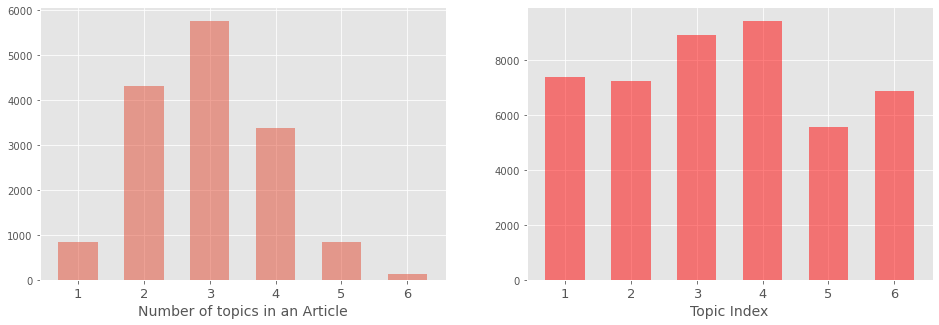

In [192]:
#num_topic_document_counter = collections.Counter(num_topic_document)
num_topic_document_counter = (pd.DataFrame(num_topic_document)).value_counts(sort=False)
counter_idx = [str(idx[0]) for idx in num_topic_document_counter.index]
counter_values = num_topic_document_counter.values
fig,axes = plt.subplots(figsize=(16,5),nrows=1,ncols=2)
axes[0].bar(counter_idx, counter_values,width=0.6,alpha=0.5)
axes[0].set_xlabel('Number of topics in an Article',fontsize=14)

df_topic_frequency = pd.DataFrame.from_dict(topic_frequency,orient='index')
topic_idxs = [str(idx+1) for idx in df_topic_frequency.index]
axes[1].bar(topic_idxs, df_topic_frequency.iloc[:,0], width=0.6,color='red',alpha=0.5)
axes[1].set_xlabel('Topic Index',fontsize=14)

for ax in axes:
    for pos in ['top','right']:
        ax.spines[pos].set_color(None)
    ax.set_xticklabels(['1','2','3','4','5','6'],fontsize=13)

In [193]:
document_topic_matrix.shape

(15056, 6)

In [194]:
## Generate document topic matrix
document_topic_matrix = np.zeros((len(corpus_risk_article),6))
for idx,document_topic in enumerate(document_topic_distribution):
    for topic_idx,prob in document_topic:
        document_topic_matrix[idx][topic_idx] = prob
pd.DataFrame(document_topic_matrix)

,0,1,2,3,4,5
0,0.155632,0.217609,0.411343,0.056965,0.155858,0.000000
1,0.000000,0.000000,0.804655,0.163225,0.000000,0.000000
2,0.389322,0.599724,0.000000,0.000000,0.000000,0.000000
3,0.536968,0.139263,0.272665,0.046590,0.000000,0.000000
4,0.000000,0.000000,0.000000,0.965991,0.000000,0.023884
...,...,...,...,...,...,...
15273,0.000000,0.595312,0.000000,0.063342,0.063392,0.275311
15274,0.000000,0.851621,0.054550,0.042248,0.047569,0.000000
15275,0.033910,0.080307,0.837662,0.000000,0.042852,0.000000
15276,0.000000,0.159431,0.832665,0.000000,0.000000,0.000000


In [195]:
tSNE = TSNE(n_components=2,init='pca',random_state=98)
embedding_matrix = tSNE.fit_transform(document_topic_matrix)
df_embedding = pd.DataFrame(embedding_matrix, columns=['X_TSNE','Y_TSNE'])
cluster_colors = {0: 'blue', 1: 'green', 2: 'yellow', 
                  3: 'red', 4: 'skyblue', 5:'salmon'}
df_embedding['dominant_topic_idx'] = np.argmax(document_topic_matrix,axis=1)
df_embedding['color'] = df_embedding['dominant_topic_idx'].map(cluster_colors)
cluster_labels = {0: 'Treatment Methods', 1: 'Mental Health and Behavior', 2: 'Severity of Disease', 
                  3: 'Transmission of Virus', 4: 'Public and Social Service', 5:'Death'}
df_embedding['label'] = df_embedding['dominant_topic_idx'].map(cluster_labels)
df_embedding['article_title'] = list(risk_article['title'])
df_embedding['article_title'] = list(risk_article['title'])
# pdf_json_files
df_embedding['pdf_json_files'] = list(risk_article['pdf_json_files'])

output_notebook()

source = ColumnDataSource(
    dict(x = df_embedding['X_TSNE'],
         y = df_embedding['Y_TSNE'],
         color=df_embedding['color'],
         label=df_embedding['label'],
         topic_key= df_embedding['dominant_topic_idx'],
         title= df_embedding['article_title'],
         #content = 
        ))

lda_plot = figure(title='T-SNE Clustering of LDA Topics', 
              plot_width=800, plot_height=600,
              tools='pan,wheel_zoom,box_zoom,reset,hover', 
              x_axis_type=None, y_axis_type=None)
lda_plot.scatter(x='x', y='y', source=source, 
                 legend='label', color='color',alpha=0.7, size=10)
hover = lda_plot.select(dict(type=HoverTool))
hover.tooltips = {'content':'Title: @title'}
lda_plot.legend.location = 'bottom_right'
show(lda_plot)

/Users/laiduy98/miniconda3/envs/ter/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(
/Users/laiduy98/miniconda3/envs/ter/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:982: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(
/Users/laiduy98/miniconda3/envs/ter/lib/python3.9/site-packages/bokeh/io/notebook.py:487: DeprecationWarning: The `source` parameter emit a  deprecation warning since IPython 8.0, it had no effects for a long time and will  be removed in future versions.
  publish_display_data(data, metadata, source, transient=transient, **kwargs)


Loading BokehJS ...

/Users/laiduy98/miniconda3/envs/ter/lib/python3.9/site-packages/bokeh/io/notebook.py:487: DeprecationWarning: The `source` parameter emit a  deprecation warning since IPython 8.0, it had no effects for a long time and will  be removed in future versions.
  publish_display_data(data, metadata, source, transient=transient, **kwargs)


/Users/laiduy98/miniconda3/envs/ter/lib/python3.9/site-packages/bokeh/io/notebook.py:487: DeprecationWarning: The `source` parameter emit a  deprecation warning since IPython 8.0, it had no effects for a long time and will  be removed in future versions.
  publish_display_data(data, metadata, source, transient=transient, **kwargs)


/Users/laiduy98/miniconda3/envs/ter/lib/python3.9/site-packages/bokeh/io/notebook.py:487: DeprecationWarning: The `source` parameter emit a  deprecation warning since IPython 8.0, it had no effects for a long time and will  be removed in future versions.
  publish_display_data(data, metadata, source, transient=transient, **kwargs)


In [196]:
df_embedding

,X_TSNE,Y_TSNE,dominant_topic_idx,color,label,article_title,pdf_json_files
0,27.704079,26.932049,2,yellow,Severity of Disease,[Development of autoimmune hemolytic anemia af...,NaN
1,51.665714,-50.303658,2,yellow,Severity of Disease,A Case of ST-Elevation Acute Myocardial Infarc...,NaN
2,3.583849,44.271160,1,green,Mental Health and Behavior,Development of a SARS‐CoV‐2 rapid antibody det...,document_parses/pdf_json/5ae79ee8c64d0641726d2...
3,9.375646,18.821701,0,blue,Treatment Methods,Effectiveness of Monoclonal Antibodies in Prev...,document_parses/pdf_json/39c7ff69712fc641faf1b...
4,-60.255913,-64.574005,3,red,Transmission of Virus,"Risk perception, mental health distress, and f...",document_parses/pdf_json/ac6322cbebc7883e93580...
...,...,...,...,...,...,...,...
15273,-32.284676,47.320293,1,green,Mental Health and Behavior,Preparation of cellulose-based wipes treated w...,NaN
15274,17.040895,73.297676,1,green,Mental Health and Behavior,Can Resveratrol-Inhaled Formulations Be Consid...,NaN
15275,79.575768,10.390853,2,yellow,Severity of Disease,Lymphopenia is Associated with Severe Coronavi...,NaN
15276,80.735069,25.890362,2,yellow,Severity of Disease,Association of endothelial activation assessed...,NaN


In [197]:
df_final = df_embedding[df_embedding['dominant_topic_idx'] == 2]

In [198]:
# all_json = ! ls $root_path/document_parses/pdf_json
# all_json = meta_df['pdf_json_files'].tolist()
all_json = df_final['pdf_json_files'].dropna()
len(all_json)

2017

In [199]:
all_json = all_json.str.split('; ').str[0]

In [200]:
len(all_json)

2017

In [202]:
all_json = [root_path + "/" + s for s in all_json]
# all_json = [root_path + "" + s for s in all_json]

all_json[:5]

['../../archive/document_parses/pdf_json/73e62e56ee31bf9ee8c1aad460d5614d133ab859.json',
 '../../archive/document_parses/pdf_json/7712cf07ffbe4b5212ed6c4886d91c8d425af9f6.json',
 '../../archive/document_parses/pdf_json/ffc34f375e03e17d9f368c2d891f0de7fcb3ad33.json',
 '../../archive/document_parses/pdf_json/0c2a6c9a703cd55e3f9f4f7b9c467ded3c9227c8.json',
 '../../archive/document_parses/pdf_json/228be1351dbfa6253c62056d3ebea49851743426.json']

In [203]:
with open(all_json[0]) as file:
    x = json.load(file)
x['paper_id']

# meta_df['sha']

'73e62e56ee31bf9ee8c1aad460d5614d133ab859'

In [204]:
class FileReader:
    def __init__(self, file_path):
        with open(file_path) as file:
            content = json.load(file)
            self.paper_id = content['paper_id']
            # self.publish_time = content['publish_time']
            self.abstract = []
            self.body_text = []
            # Abstract
            for entry in content['abstract']:
                self.abstract.append(entry['text'])
            # Body text
            for entry in content['body_text']:
                self.body_text.append(entry['text'])
            self.abstract = '\n'.join(self.abstract)
            self.body_text = '\n'.join(self.body_text)
    def __repr__(self):
        return f'{self.paper_id}: {self.abstract[:200]}... {self.body_text[:200]}...'
first_row = FileReader(all_json[0])
print(first_row)

73e62e56ee31bf9ee8c1aad460d5614d133ab859: Background: Exact information about the efficacy of various medications proposed by regulatory bodies in children with COVID-19 is limited due to the lack of controlled trials in the existing literatu... After its discovery in December 2019 in Wuhan, China, it has been more than one and a half years now; still, the world has not recovered from the COVID-19 pandemic. India is among one of the worst hit...


In [205]:
from tqdm import tqdm
all_json_clean = list()
for idx, entry in tqdm(enumerate(all_json), total=len(all_json)):
    
    try:
        content = FileReader(entry)
    except Exception as e:
        continue  # invalid paper format, skip
    
    if len(content.body_text) == 0:
        continue
    
    all_json_clean.append(all_json[idx])
    
all_json = all_json_clean
len(all_json)

100%|████████████████████████████████████████████████████████████████████| 2017/2017 [00:02<00:00, 831.17it/s]


2005

In [206]:
import random

random.seed(42)

all_json = random.sample(all_json, 1000)

In [207]:
all_json[:5]

['../../archive/document_parses/pdf_json/26c3c1390e46cb506f47be10dcff4f1ec8471f17.json',
 '../../archive/document_parses/pdf_json/fe05e01efd3149fa78c15fed574a8feba5c37f42.json',
 '../../archive/document_parses/pdf_json/1b3afd29eadadfb1c8db836efd6dacaaf3048da4.json',
 '../../archive/document_parses/pdf_json/0198a37e6359b182f1c0b60ed0167a6c2ba06492.json',
 '../../archive/document_parses/pdf_json/9105cb1fe4ca2bb7f745e42db94d37482f9bb460.json']

In [208]:
def get_breaks(content, length):
    data = ""
    words = content.split(' ')
    total_chars = 0

    # add break every length characters
    for i in range(len(words)):
        total_chars += len(words[i])
        if total_chars > length:
            data = data + "<br>" + words[i]
            total_chars = 0
        else:
            data = data + " " + words[i]
    return data

In [209]:
from tqdm import tqdm
dict_ = {'paper_id': [], 'doi':[], 'abstract': [], 'body_text': [], 'authors': [], 'title': [], 'journal': [], 'abstract_summary': [], 'publish_time': []}
for idx, entry in tqdm(enumerate(all_json), total = len(all_json)):
    
    try:
        content = FileReader(entry)
    except Exception as e:
        continue  # invalid paper format, skip
    
    # get metadata information
    meta_data = meta_df.loc[meta_df['sha'] == content.paper_id]
    # no metadata, skip this paper
    if len(meta_data) == 0:
        continue
    if len(content.body_text) == 0:
        continue
    dict_['abstract'].append(content.abstract)
    dict_['paper_id'].append(content.paper_id)
    dict_['body_text'].append(content.body_text)
    # dict_['publish_time'].append(content.publish_time)
    
    # also create a column for the summary of abstract to be used in a plot
    if len(content.abstract) == 0: 
        # no abstract provided
        dict_['abstract_summary'].append("Not provided.")
    elif len(content.abstract.split(' ')) > 100:
        # abstract provided is too long for plot, take first 300 words append with ...
        info = content.abstract.split(' ')[:100]
        summary = get_breaks(' '.join(info), 40)
        dict_['abstract_summary'].append(summary + "...")
    else:
        # abstract is short enough
        summary = get_breaks(content.abstract, 40)
        dict_['abstract_summary'].append(summary)
        
    # get metadata information
    meta_data = meta_df.loc[meta_df['sha'] == content.paper_id]
    
    try:
        # if more than one author
        authors = meta_data['authors'].values[0].split(';')
        if len(authors) > 2:
            # more than 2 authors, may be problem when plotting, so take first 2 append with ...
            dict_['authors'].append(get_breaks('. '.join(authors), 40))
        else:
            # authors will fit in plot
            dict_['authors'].append(". ".join(authors))
    except Exception as e:
        # if only one author - or Null valie
        dict_['authors'].append(meta_data['authors'].values[0])
    
    # add the title information, add breaks when needed
    try:
        title = get_breaks(meta_data['title'].values[0], 40)
        dict_['title'].append(title)
    # if title was not provided
    except Exception as e:
        dict_['title'].append(meta_data['title'].values[0])
    
    # add the journal information
    dict_['journal'].append(meta_data['journal'].values[0])
    
    # add doi
    dict_['doi'].append(meta_data['doi'].values[0])
    
df_covid = pd.DataFrame(dict_, columns=['paper_id', 'doi', 'abstract', 'body_text', 'authors', 'title', 'journal', 'abstract_summary'])
df_covid.head()

100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:27<00:00, 35.93it/s]


,paper_id,doi,abstract,body_text,authors,title,journal,abstract_summary
0,26c3c1390e46cb506f47be10dcff4f1ec8471f17,10.2147/copd.s333274,These authors contributed equally to this work...,Chronic Obstructive Pulmonary Disease (COPD) i...,"Mao, Ruolin. Liu, Zilong. Zhao, Yunfeng. D...",Stable Chronic Obstructive Pulmonary Disease<...,Int J Chron Obstruct Pulmon Dis,These authors contributed equally to this wor...
1,fe05e01efd3149fa78c15fed574a8feba5c37f42,10.3389/fimmu.2021.700449,,Coronavirus disease 2019 (COVID-19) is a self-...,"Shi, Lei. Ding, Rong. Zhang, Tingting. Wu,...",Comparative Characterization and Risk<br>Stra...,Front Immunol,Not provided.
2,1b3afd29eadadfb1c8db836efd6dacaaf3048da4,10.1038/s41390-021-01493-8,BACKGROUND: Bronchopulmonary dysplasia (BPD) i...,"Despite advances in neonatal intensive care, b...","Gerull, Roland. Neumann, Roland P.. Atkinso...",Respiratory morbidity in preterm infants<br>p...,Pediatr Res,BACKGROUND: Bronchopulmonary dysplasia<br>(BP...
3,0198a37e6359b182f1c0b60ed0167a6c2ba06492,10.1159/000517180,Introduction: The aim of this was to describe ...,The World Health Organization declared a pande...,"Sahin, Serdar. Sezer, Havva. Cicek, Ebru. <...",The Role of Obesity in Predicting the Clinica...,Obes Facts,Introduction: The aim of this was to describe...
4,9105cb1fe4ca2bb7f745e42db94d37482f9bb460,10.11604/pamj.2022.41.101.28751,,Le travail visait à rapporter les cas de co-in...,"Igala, Marielle. Bivigou, Elsa Ayo. Kombila...",Co-infection paludisme et COVID-19 chez les<b...,Pan Afr Med J,Not provided.


In [ ]:
# df_covid['body_text'][2]

# Preprocessing
## Handling multiple languages for body_text

In [210]:
from tqdm import tqdm
from langdetect import detect
from langdetect import DetectorFactory

# set seed
DetectorFactory.seed = 0

# hold label - language
languages = []

# go through each text
for ii in tqdm(range(0,len(df_covid))):
    # split by space into list, take the first x intex, join with space
    text = df_covid.iloc[ii]['body_text'].split(" ")
    
    lang = "en"
    try:
        if len(text) > 50:
            lang = detect(" ".join(text[:50]))
        elif len(text) > 0:
            lang = detect(" ".join(text[:len(text)]))
    # ught... beginning of the document was not in a good format
    except Exception as e:
        all_words = set(text)
        try:
            lang = detect(" ".join(all_words))
        # what!! :( let's see if we can find any text in abstract...
        except Exception as e:
            
            try:
                # let's try to label it through the abstract then
                lang = detect(df.iloc[ii]['abstract_summary'])
            except Exception as e:
                lang = "unknown"
                pass
    
    # get the language    
    languages.append(lang)

100%|██████████████████████████████████████████████████████████████████████| 930/930 [00:04<00:00, 199.80it/s]


In [211]:
from pprint import pprint

languages_dict = {}
for lang in set(languages):
    languages_dict[lang] = languages.count(lang)
    
print("Total: {}\n".format(len(languages)))
pprint(languages_dict)

Total: 930

{'de': 6, 'en': 918, 'es': 3, 'fr': 3}


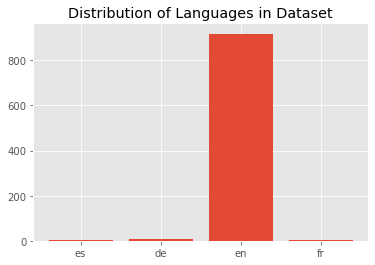

In [212]:
df_covid['language'] = languages
plt.bar(range(len(languages_dict)), list(languages_dict.values()), align='center')
plt.xticks(range(len(languages_dict)), list(languages_dict.keys()))
plt.title("Distribution of Languages in Dataset")
plt.show()

In [213]:
df = df_covid[df_covid['language'] == 'en'] 
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 918 entries, 0 to 928
Data columns (total 9 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   paper_id          918 non-null    object
 1   doi               915 non-null    object
 2   abstract          918 non-null    object
 3   body_text         918 non-null    object
 4   authors           918 non-null    object
 5   title             918 non-null    object
 6   journal           868 non-null    object
 7   abstract_summary  918 non-null    object
 8   language          918 non-null    object
dtypes: object(9)
memory usage: 71.7+ KB


In [214]:
def utils_preprocess_text(text, flg_stemm=False, flg_lemm=True, lst_stopwords=None):
    ## clean (convert to lowercase and remove punctuations and characters and then strip)
    text = re.sub(r'[^\w\s]', '', str(text).lower().strip())
    pat = r'\d+'
    text = re.sub(pat, '', text)
    # r'[^a-zA-z0-9.,!?/:;\"\'\s]
    # r'[^\w\s]
    
    # text = text.replace(r'\d+','')
            
    ## Tokenize (convert from string to list)
    lst_text = text.split()
    ## remove Stopwords
    if lst_stopwords is not None:
        lst_text = [word for word in lst_text if word not in 
                    lst_stopwords]
        
    # removed_numbers = dataframe.str.replace(r'\d+','')
        
                
    ## Stemming (remove -ing, -ly, ...)
    if flg_stemm == True:
        ps = nltk.stem.porter.PorterStemmer()
        lst_text = [ps.stem(word) for word in lst_text]
                
    ## Lemmatisation (convert the word into root word)
    if flg_lemm == True:
        lem = nltk.stem.wordnet.WordNetLemmatizer()
        lst_text = [lem.lemmatize(word) for word in lst_text]
            
    ## back to string from list
    text = " ".join(lst_text)
    return text

In [215]:
def apply_preprocess(df):
    df["body_text_clean"] = df["body_text"].apply(lambda x: 
              utils_preprocess_text(x, flg_stemm=False, flg_lemm=True, 
              lst_stopwords=lst_stopwords))
    return df

In [216]:
def apply_preprocess_abstract(df):
    df["abstract_clean"] = df["abstract"].apply(lambda x: 
              utils_preprocess_text(x, flg_stemm=False, flg_lemm=True, 
              lst_stopwords=lst_stopwords))
    return df

In [217]:
df = apply_preprocess(df)

/var/folders/yf/jsht06l94t5_wb6s1c65k6v40000gn/T/ipykernel_19742/124836987.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["body_text_clean"] = df["body_text"].apply(lambda x:


In [ ]:
df = apply_preprocess_abstract(df)
df.head()

In [ ]:
# df_test[df_test['abstract_ris_index'] != -1]['abstract_clean']

In [ ]:
df_test = df_test[df_test['abstract_sev_index'] != -1 or df_test['abstract_ris_index'] != -1]

In [ ]:
df['body_text_clean'][0]

In [ ]:
df_test.head()

In [ ]:
# !pip install scispacy
# !pip install https://s3-us-west-2.amazonaws.com/ai2-s2-scispacy/releases/v0.5.0/en_ner_bc5cdr_md-0.5.0.tar.gz
# !pip install https://s3-us-west-2.amazonaws.com/ai2-s2-scispacy/releases/v0.5.0/en_ner_bionlp13cg_md-0.5.0.tar.gz

In [218]:
import scispacy
import spacy
nlp = spacy.load("en_ner_bc5cdr_md")
nlp_model_bionlp13cg = spacy.load('en_ner_bionlp13cg_md') # For cells, genes, ...


In [ ]:
# doc = nlp(df['body_text_clean'][109])

In [ ]:
# print("TEXT", "START", "END", "ENTITY TYPE")
# for ent in doc.ents:
#     print(ent.text, ent.start_char, ent.end_char, ent.label_)

In [ ]:
entities = []
labels = []
position_start = []
position_end = []

for body_text in tqdm(df['body_text_clean'][:200]):
    doc = nlp(body_text)
    

    for ent in doc.ents:
        entities.append(ent.text)
        labels.append(ent.label_)
        position_start.append(ent.start_char)
        position_end.append(ent.end_char)

    named_entities_df = pd.DataFrame({'Entities':entities,'Labels':labels,'Position_Start':position_start, 'Position_End':position_end})


100%|███████████████████████████████████████████████████████████████████████| 200/200 [00:53<00:00,  3.77it/s]


In [223]:
df_disease = named_entities_df

In [224]:
df_disease['Entities'] = named_entities_df['Entities'].str.lower()

In [225]:
df_disease = named_entities_df.drop_duplicates(subset=['Entities'])

In [226]:
df_disease

,Entities,Labels,Position_Start,Position_End
0,chronic obstructive pulmonary disease copd,DISEASE,0,42
1,death,DISEASE,49,54
3,copd,DISEASE,188,192
9,dyspnea,DISEASE,2353,2360
10,cough,DISEASE,2369,2374
...,...,...,...,...
15193,alveolar airspace disease,DISEASE,1673,1698
15194,covid pneumonia pulmonary embolism,DISEASE,1710,1744
15197,cook medical blue rhino,CHEMICAL,2382,2405
15199,mupirocin,CHEMICAL,2728,2737


In [231]:
df_disease[df_disease['Labels'] == 'DISEASE'].to_csv('disease.csv')